In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle 
import time
from matplotlib import style

style.use("ggplot")

In [2]:
SIZE = 10                     # 10 by 10 Grid (Our Enviroment)
EPISODES = 40000              # Total Episodes
MOVE_REWARD = -1              # Reward per move 
ENEMY_REWARD = -300           # Reward on reaching enemy
GOAL_REWARD = 25              # Reward on reaching goal
epsilon = 0.5                 # Epsilon (for exploration and exploitation trade off)
START_EPSILON = 10            # Starting Episode for using epsilon
END_EPSILON = EPISODES // 2   # Ending Episode for using epsilon
EPSILON_DECAY = epsilon / (END_EPSILON - START_EPSILON) # Decay 
SHOW_EVERY = 2000             # For printing message every 2000 episodes
LEARNING_RATE = 0.1           # Learning Rate
DISCOUNT = 0.9                # Discount Factor

initial_q_table = None        # Pre-existing Q-Table can be given here

PLAYER_I = 1                  # Player index in dictionary
GOAL_I = 2                    # Goal index in dictionary
ENEMY_I = 3                   # Enemy index in dictionary

color = {1:(255,0,0),2:(0,255,0),3:(0,0,255)} # PLAYER - BLUE , GOAL - GREEN , ENEMY - RED (BGR for open-cv) 

In [3]:
class Square():
    def __init__(self): # constructor
        self.x = np.random.randint(0,SIZE)
        self.y = np.random.randint(0,SIZE)
        
    def __str__(self):
        return f"{self.x},{self.y}"
    
    def __sub__(self,other): # operator overloading
        return (self.x-other.x,self.y-other.y)
    
    def action(self,choice): # 4 choices
        if choice==0:
            self.move(x=1,y=1)
        elif choice==1:
            self.move(x=-1,y=-1)
        elif choice==2:
            self.move(x=1,y=-1)
        elif choice==3:
            self.move(x=-1,y=1)
            
    def move(self,x=False,y=False): # moving depending on choices
        if not x:
            self.x += np.random.randint(-1,2)
        else:
            self.x += x
            
        if not y:
            self.y += np.random.randint(-1,2)
        else:
            self.y += y
            
        if self.x < 0:
            self.x = 0
        elif self.x >= SIZE:
            self.x = SIZE-1
            
        if self.y < 0:
            self.y = 0
        elif self.y >= SIZE:
            self.y = SIZE-1

In [4]:
player = Square()
enemy = Square()
goal = Square()

print(player)
print(enemy)
print(goal)
# player.action(3)
# player.move()
# print(player)

2,6
1,1
8,6


In [5]:
if initial_q_table is None: # Q-Table Initilising
    q_table = {}
    for x1 in range(-SIZE+1,SIZE):
        for y1 in range(-SIZE+1,SIZE):
            for x2 in range(-SIZE+1,SIZE):
                for y2 in range(-SIZE+1,SIZE):
                    # q_table[((x1,y1),(x2,y2))] = [np.random.uniform(-5, 0) for i in range(4)]
                    q_table[((x1,y1),(x2,y2))] = [0,0,0,0]
else:
    with open(initial_q_table, "rb") as f:
        q_table = pickle.load(f)

In [6]:
episode_rewards = [] # stores rewards per episode

for episode in range(EPISODES):
    player = Square()
    enemy = Square()
    goal = Square()
    
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, Epsilon is {epsilon}")
        print(f"Last {SHOW_EVERY} Episode Rewards Mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
        
    episode_reward = 0 # to store reward per episode
    for i in range(200): # max steps is 200
        obs = (player-goal,player-enemy) # current observation state
        
        if np.random.random() > epsilon: # best action according to Q-Table
            action = np.argmax(q_table[obs])
        else:                            # random action for exploration
            action = np.random.randint(0,4)
            
        player.action(action) # taking that action
         
        #enemy.move()
        #goal.move()
        
        if player.x == enemy.x and player.y == enemy.y: # if lands on enemy
            reward = ENEMY_REWARD # reward for that step
        elif player.x == goal.x and player.y == goal.y: # if lands on goal
            reward = GOAL_REWARD # reward for that step
        else:                                           # just a normal step
            reward = MOVE_REWARD # reward for that step
            
        new_obs = (player-goal,player-enemy) # new observation state after taking action
        max_future_q = np.max(q_table[new_obs]) # max q_value for new state
        current_q = q_table[obs][action] # current q_value for action taken
        
        if reward == GOAL_REWARD: # if goal was reached
            new_q = reward
        else:                     # otherwise update q_value
            new_q = ((1-LEARNING_RATE)*current_q) + (LEARNING_RATE*(reward + (DISCOUNT*(max_future_q))))
        q_table[obs][action] = new_q # store in Q-Table
            
        if show: # to show real time movement in open-cv window
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8) # Black Board
            env[goal.x][goal.y] = color[GOAL_I]             # Position of goal in green 
            env[player.x][player.y] = color[PLAYER_I]       # Position of player in blue
            env[enemy.x][enemy.y] = color[ENEMY_I]          # Position of enemy in red
            img = Image.fromarray(env, 'RGB')               # Returns image object
            img = img.resize((300, 300))                    # Resizing 
            cv2.imshow("Board", np.array(img))  
            if reward == GOAL_REWARD or reward == ENEMY_REWARD: 
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
        episode_reward += reward # add to the episode reward list
        
        if reward == GOAL_REWARD or reward == ENEMY_REWARD: # if goal or enemy reached then end episode
            break
    
    episode_rewards.append(episode_reward) # append it to the list of all episode rewards
    
    if END_EPSILON >= episode >= START_EPSILON: # episodes between which to decay epsilon
        epsilon -= EPSILON_DECAY
        
cv2.destroyAllWindows() # close all windows

on #0, Epsilon is 0.5
Last 2000 Episode Rewards Mean: nan


C:\Users\Vidit\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vidit\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #2000, Epsilon is 0.45022511255624853
Last 2000 Episode Rewards Mean: -162.8585
on #4000, Epsilon is 0.40020010004996565
Last 2000 Episode Rewards Mean: -117.11
on #6000, Epsilon is 0.35017508754368276
Last 2000 Episode Rewards Mean: -85.1535
on #8000, Epsilon is 0.3001500750373999
Last 2000 Episode Rewards Mean: -68.934
on #10000, Epsilon is 0.250125062531117
Last 2000 Episode Rewards Mean: -61.5225
on #12000, Epsilon is 0.2001000500248895
Last 2000 Episode Rewards Mean: -51.8895
on #14000, Epsilon is 0.15007503751866214
Last 2000 Episode Rewards Mean: -49.7895
on #16000, Epsilon is 0.10005002501242091
Last 2000 Episode Rewards Mean: -41.448
on #18000, Epsilon is 0.050025012506165784
Last 2000 Episode Rewards Mean: -33.761
on #20000, Epsilon is -8.851942209829947e-14
Last 2000 Episode Rewards Mean: -30.203
on #22000, Epsilon is -2.5012506341645987e-05
Last 2000 Episode Rewards Mean: -22.2725
on #24000, Epsilon is -2.5012506341645987e-05
Last 2000 Episode Rewards Mean: -22.8645
on #

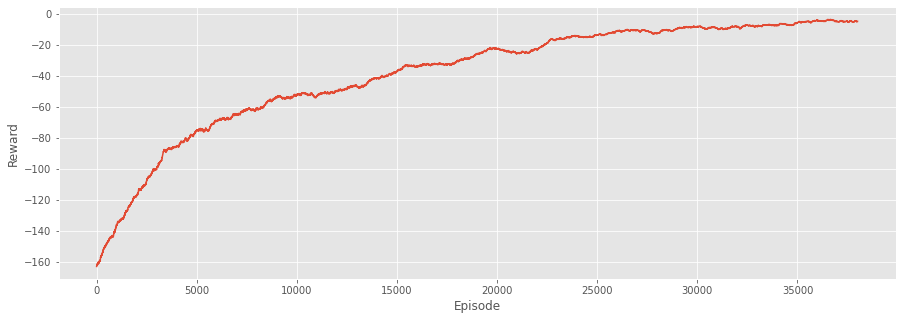

In [7]:
avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.figure(figsize=(15,5))
plt.plot([i for i in range(len(avg))], avg)
plt.ylabel(f"Reward")
plt.xlabel("Episode")
plt.show()

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)